In [1]:
import pandas as pd
import os
import re
from datetime import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Merging the Data to a single DF

In [2]:
def find_all_files(path, ty='csv', Name='Merged_DF.csv'):
    #Iteratively appends all files with ty extention to list_of_files
    for root,dirs,files in os.walk(path):
        [list_of_files.append(file) for file in files if (file.endswith(f".{ty}") and (file!=Name))]

In [3]:
Name = 'Merged_DF.csv' #Name of Final DF
list_of_files = []
data_path = os.path.join('..', 'Data')
find_all_files(data_path, Name=Name)

Total_DF = pd.DataFrame()
for file in list_of_files:
    try:
        DF = pd.read_csv(os.path.join('..', 'Data', file), encoding='utf-8')
    except:
        DF = pd.read_csv(os.path.join('..', 'Data', file), encoding='latin1')
    Total_DF = (DF if Total_DF.empty else pd.concat([Total_DF, DF]))

# Total DF Cleaning

In [4]:
#Total_DF['video_id'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['trending_date'].map(lambda x: type(x)!=str).sum() #All values are string
#Convert the 'trending_date' to date format
Total_DF['trending_date'] = Total_DF['trending_date'].map(lambda x: dt.strptime(x, "%y.%d.%m"))

#Total_DF['title'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['channel_title'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['category_id'].map(lambda x: type(x)!=int).sum() #All values are int
#Total_DF['publish_time'].map(lambda x: type(x)!=str).sum() #All values are string
#Convert the 'publish_time' to date format
Total_DF['publish_time'] = pd.to_datetime(Total_DF['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ') #%f means microsecond which means 6 digits. This works here as it is always 0 microseconds
#Total_DF['tags'].map(lambda x: type(x)!=str).sum() #All values are string
#Total_DF['views'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['likes'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['dislikes'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['comment_count'].map(lambda x: type(x)!=int).sum() #All values are int64
#Total_DF['likes'].isnull().sum()
#Total_DF['dislikes'].isnull().sum()
#Total_DF['comment_count'].isnull().sum()
#Total_DF['thumbnail_link'].isnull().sum()
#Total_DF['comments_disabled'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['ratings_disabled'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['video_error_or_removed'].map(lambda x: type(x)!=bool).sum() #All values are boolean
#Total_DF['comments_disabled'].isnull().sum()
#Total_DF['ratings_disabled'].isnull().sum()
#Total_DF['video_error_or_removed'].isnull().sum()

#Convert NaN values in 'description' to ''
Total_DF['description'].fillna(value='', inplace=True)
#Total_DF['description'].isna().sum()
#Total_DF[Total_DF['description'] == ''].shape

# Removing for duplicate rows

In [5]:
#Drop the duplicate rows
Total_DF.drop_duplicates(subset=['video_id', 'trending_date'], keep='last', inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
to_drop = Total_DF[(Total_DF['video_id']=='#NAME?') | (Total_DF['video_id']=='#VALUE!')].index
Total_DF.drop(to_drop, inplace=True)
Total_DF.reset_index(drop=True, inplace=True)
Total_DF.shape
#375942 - 52212 - 205 -7  = 323518

(323518, 16)

In [6]:
Total_DF.dtypes

video_id                          object
trending_date             datetime64[ns]
title                             object
channel_title                     object
category_id                        int64
publish_time              datetime64[ns]
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
description                       object
dtype: object

# Save the DataFrame as pickle 

In [7]:
Total_DF.to_pickle("../Data/VideoDF.pkl")

# Read from pickle

In [8]:
Video_DF = pd.read_pickle("../Data/VideoDF.pkl")

In [9]:
Video_DF.dtypes
Video_DF.duplicated(subset=['video_id', 'trending_date'], keep='last').sum()

video_id                          object
trending_date             datetime64[ns]
title                             object
channel_title                     object
category_id                        int64
publish_time              datetime64[ns]
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled                   bool
ratings_disabled                    bool
video_error_or_removed              bool
description                       object
dtype: object

0

##  Total Trend Days Vs Maximum Continuous Trend Days

What is typically the pattern of trend ? Is it continuous trending or sporadic ?

A very high correlation (0.98) between the total trend days and the maximum of  continuous trend days show Trending is a continuous pattern. 

Also, 99% of the trendings was continuous without a break and only 1% had a break in trending

### Derive Total Trending Days

In [10]:
Trending_Days = Video_DF.groupby('video_id').aggregate(First_Trend_Date=('trending_date', 'min'), Last_Trend_Date=('trending_date', 'max'), Total_Trend_Days=('trending_date', 'count'))


In [11]:
Trending_Days.head()

,First_Trend_Date,Last_Trend_Date,Total_Trend_Days
video_id,,,
--1skHapGUc,2018-02-10,2018-02-10,1
--2K8l6BWfw,2018-03-06,2018-03-06,1
--45ws7CEN0,2018-06-12,2018-06-12,1
--6vcer7XYQ,2018-03-23,2018-03-25,3
--728h8mnDY,2017-12-06,2017-12-07,2


### Continuity of Trending

In [12]:
Videos_Trended_more_than_1day =  Trending_Days[Trending_Days['Total_Trend_Days']>1].index.to_list()
Sorted_Video_DF = Video_DF.sort_values(by=['video_id', 'trending_date'])  
Video_grp = Sorted_Video_DF.groupby('video_id')
Video_Trending_Dates = Video_grp.aggregate(Trending_Dates = ('trending_date', lambda x: x.to_list()))

In [13]:
#Maximum Continuous Days of Trending
def find_max_period(dates):
    period=1
    max_periods = 1
    for index, date in enumerate(dates[:-1]):
        diff = dates[index+1] - date
        
        if diff.days == 1:
            period+=1
        else:
            if max_periods < period:
                max_periods = period
            period=1
        
    return (max_periods if max_periods>period else period)
#find_max_period(Video_Trending_Dates.loc['zxwfDlhJIpw', :][0])

In [14]:
Video_Trending_Dates['Max_Perid_of_Cont_Treanding'] = Video_Trending_Dates.apply(lambda x: find_max_period(x[0]), axis=1)
Video_Trending_Dates['Trending_Dates_String'] = Video_Trending_Dates['Trending_Dates'].map(lambda L: [item.strftime("%y.%d.%m") for item in L])            
Video_Trending_Dates = Video_Trending_Dates[['Trending_Dates', 'Trending_Dates_String', 'Max_Perid_of_Cont_Treanding']]                             


In [15]:
Video_Trending_Dates.head()

,Trending_Dates,Trending_Dates_String,Max_Perid_of_Cont_Treanding
video_id,,,
--1skHapGUc,[2018-02-10 00:00:00],[18.10.02],1
--2K8l6BWfw,[2018-03-06 00:00:00],[18.06.03],1
--45ws7CEN0,[2018-06-12 00:00:00],[18.12.06],1
--6vcer7XYQ,"[2018-03-23 00:00:00, 2018-03-24 00:00:00, 201...","[18.23.03, 18.24.03, 18.25.03]",3
--728h8mnDY,"[2017-12-06 00:00:00, 2017-12-07 00:00:00]","[17.06.12, 17.07.12]",2


### Merge Total_Trend_Days and Max_Perid_of_Cont_Treanding into a single DF

In [16]:
Trending_Pattern_DF = Trending_Days.join(Video_Trending_Dates[['Trending_Dates_String', 'Max_Perid_of_Cont_Treanding']])
Trending_Pattern_DF = Trending_Pattern_DF[['First_Trend_Date', 'Last_Trend_Date', 'Trending_Dates_String', 'Total_Trend_Days','Max_Perid_of_Cont_Treanding']]


In [17]:
Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].head()

Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].head()


,First_Trend_Date,Last_Trend_Date,Trending_Dates_String,Total_Trend_Days,Max_Perid_of_Cont_Treanding
video_id,,,,,
--1skHapGUc,2018-02-10,2018-02-10,[18.10.02],1,1
--2K8l6BWfw,2018-03-06,2018-03-06,[18.06.03],1,1
--45ws7CEN0,2018-06-12,2018-06-12,[18.12.06],1,1
--6vcer7XYQ,2018-03-23,2018-03-25,"[18.23.03, 18.24.03, 18.25.03]",3,3
--728h8mnDY,2017-12-06,2017-12-07,"[17.06.12, 17.07.12]",2,2


,First_Trend_Date,Last_Trend_Date,Trending_Dates_String,Total_Trend_Days,Max_Perid_of_Cont_Treanding
video_id,,,,,
-3VBPAZPTQI,2017-12-31,2018-01-15,"[17.31.12, 18.01.01, 18.02.01, 18.03.01, 18.04...",14,10
-8X32zNup1o,2018-05-23,2018-06-11,"[18.23.05, 18.04.06, 18.05.06, 18.06.06, 18.07...",9,8
-BDImdAfodA,2018-02-02,2018-03-07,"[18.02.02, 18.03.02, 18.04.02, 18.05.02, 18.06...",32,29
-CS84oCtjvc,2018-02-16,2018-02-23,"[18.16.02, 18.21.02, 18.22.02, 18.23.02]",4,3
-DRsfNObKIQ,2018-05-09,2018-06-14,"[18.09.05, 18.10.05, 18.11.05, 18.12.05, 18.13...",36,31


In [18]:
Trending_Pattern_DF.columns

Index(['First_Trend_Date', 'Last_Trend_Date', 'Trending_Dates_String',
       'Total_Trend_Days', 'Max_Perid_of_Cont_Treanding'],
      dtype='object')

### Plotting to demonstrate correlation

### Simple scatter plot doesn't capture this well as it doesn't show the density for large datasets with same values

In [19]:
above = 20 
below = Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()
Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

x = Target['Total_Trend_Days']
y = Target['Max_Perid_of_Cont_Treanding']

<Figure size 432x288 with 0 Axes>

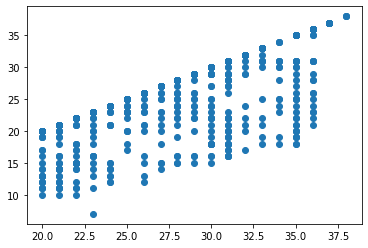

In [20]:
plt.figure()
plt.scatter(x,y)
plt.show()

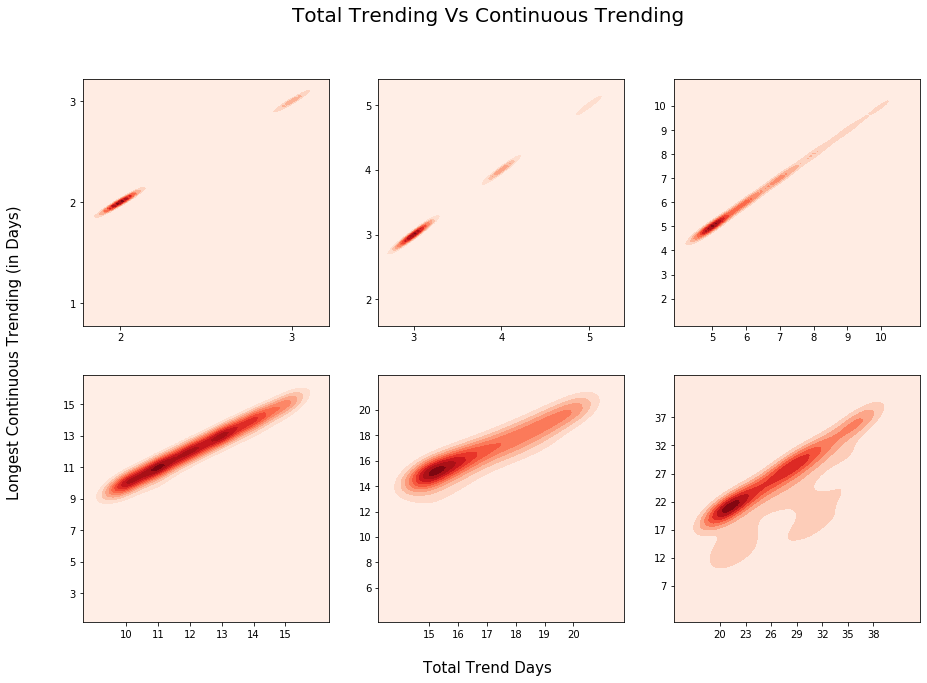

In [22]:
above_below = [2,3,5,10,15,20,Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()]

fig, axes = plt.subplots(2,3, figsize=(15,10))
Axes = axes.flat

for index, val in enumerate(above_below[:-1]):
    above =  val
    below = above_below[index+1]
    Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

    
    x = Target['Total_Trend_Days']
    y = Target['Max_Perid_of_Cont_Treanding']
    
    _ = sns.kdeplot(x,y, cmap="Reds", shade=True, ax=Axes[index])

    #Disable individual labels
    _=Axes[index].set_xlabel('')
    _=Axes[index].set_ylabel('')
    
    #Custom xticks
    stepx = (1 if len(range(x.min(), x.max()+1))<=6 else  len(range(x.min(), x.max()+1))//6)
    stepy = (1 if len(range(y.min(), y.max()+1))<=6 else  len(range(y.min(), y.max()+1))//6)
    
    _=Axes[index].set_xticks(list(range(x.min(), x.max()+1, stepx)))
    _=Axes[index].set_yticks(list(range(y.min(), y.max()+1, stepy)))
    
#Common Labels
_ = fig.suptitle('Total Trending Vs Continuous Trending', fontsize=20)
_ = fig.text(0.5, 0.055, 'Total Trend Days', ha='center', fontsize=15)
_ = fig.text(0.055, 0.5, 'Longest Continuous Trending (in Days)', va='center', rotation='vertical', fontsize=15)

#Save figure
fig.savefig('../Image/Total_Trending_Vs_Continuous_Trending.png')

### Find the correlation between Max_Perid_of_Cont_Treanding ("Popularity") Vs. Total_Trend_Days

In [23]:
st.pearsonr(Trending_Pattern_DF['Total_Trend_Days'], Trending_Pattern_DF['Max_Perid_of_Cont_Treanding'])

(0.9856997456497165, 0.0)

In [24]:
#Percentge wise comparison on continuity
100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Perid_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

99.06394986027078

0.9360501397292238